
###  **Project: Predictive Maintenance for Wind Turbines**

---

#### **Problem Statement**

You are tasked with designing a machine learning-based predictive maintenance system for wind turbines on behalf of a customer. The objective is to build a system that:

* Predicts **all failure events** as early as possible,
*  Minimizes the **false alarm rate** to avoid unnecessary maintenance.

We focus on **Wind Farm C**, as described in the dataset accompanying \[1].

---

####  **Work Package 1 – Data Analysis and Feature Selection**

We use one year of SCADA data from Wind Farm C, containing 10-minute-interval readings from 238 sensors, totaling **52,560 samples**. Each sensor is represented with statistical aggregates such as mean, standard deviation, min, and max, leading to **957 features**.

To prepare high-quality input for ML models:

* ✅ **Operational status filtering**: We include only status types corresponding to normal operation (status\_type\_id 0 or 2).
* ✅ **Noise removal**: DBSCAN clustering is used to eliminate outliers in wind-power space.
* ✅ **Ideal power curve fitting**: A polynomial power curve with ±3σ bounds ensures only realistic, healthy operational data is retained.
* ✅ **Correlation-based feature filtering**: Highly correlated sensor features are reduced using domain-prioritized ranking.
* ✅ **Low-variance & redundant feature elimination**: Features with low variability or mostly zero values are dropped.

>  Final feature set includes power, temperature, generator, gearbox, and vibration features — selected for their relevance to fault dynamics.

---

####  **Work Package 2 – Modeling and Evaluation**

We implement and compare two strategies:

---

### 1️⃣ **Unsupervised Approach – KMeans Clustering**

* **Training**: Only on normal operational data.
* **Anomaly scoring**: Based on distance to the learned cluster centroid.
* **Detection**: A 99th percentile threshold is applied to smoothed anomaly scores.
* **Lead time achieved**: **3 days **
* **False alarm rate**:  **1.07%**
* **Performance**:

  * Accuracy: **95%**
  * Precision (fault): High
  * Recall (fault): Strong early detection

---

### 2️⃣ **Supervised Approach – XGBoost Classifier**

* **Labeling**:

  * Pre-failure window (last 24h) → Anomalous (1)
  * Others → Normal (0)
* **Data balancing**: 10,000 normal samples + all anomaly samples
* **Model config**: 100 rounds, depth=5, learning rate=0.1, `scale_pos_weight` adjusted
* **Lead time achieved**: ⏱️ **22 hours 40 minutes**
* **False alarm rate on healthy data**:  **0.00%**
* **Performance metrics**:

  * Accuracy: **96.1%**
  * F1-Score (anomaly): **0.868**
  * Confusion matrix: Very low FN and FP rates

---

####  **Figures and Visualizations**

* Anomaly timelines for each approach
* Histogram of anomaly scores
* Confusion matrices
* DBSCAN cleaning before/after
* Power curve with ±3σ bounds

---

####  **Conclusion**

Both methods successfully meet the customer’s requirements of **early detection** and **low false alarm rate**:

| Approach | Lead Time | Accuracy | False Alarm Rate | F1 (Anomaly) | Notes                      |
| -------- | --------- | -------- | ---------------- | ------------ | -------------------------- |
| KMeans   | 3d    | 95%      | 1.07%            | High         | Needs only normal data     |
| XGBoost  | 22h 40min | 96.1%    | 0.00%            | 0.868        | Requires labeled anomalies |


References used :

https://www.sciencedirect.com/science/article/pii/S2666546824000399?via%3Dihub#b16

https://www.mdpi.com/1996-1073/13/5/1063

https://www.sciencedirect.com/science/article/pii/S2666546821000197?via%3Dihub#bib0030

https://www.sciencedirect.com/science/article/pii/S096014811831231X?via%3Dihub#bbib48

https://www.sciencedirect.com/science/article/pii/S096014811831231X?via%3Dihub#bib48

https://www.sciencedirect.com/science/article/pii/S2666546821000197?via%3Dihub#bib0030

https://sciprofiles.com/profile/3768337?utm_source=mdpi.com&utm_medium=website&utm_campaign=avatar_name

https://arxiv.org/pdf/2404.10320

https://energyinformatics.springeropen.com/articles/10.1186/s42162-022-00252-1

https://ieeexplore.ieee.org/document/9530585



###  Data Splitting and Pre-Failure Context Preparation

This section loads the complete SCADA dataset along with annotated event information for Wind Farm C. The objective is to construct a realistic and informative **train-test split** for supervised learning. The `train_test` column in the dataset indicates whether a sample should be used for training or prediction.

The test set is extended by including a **24-hour pre-failure window** preceding each known anomaly event for a selected turbine (`asset_id = 21`). These additional pre-fault samples simulate the period where early anomaly detection is critical. To ensure no data leakage, pre-failure samples are extracted from the training set and appended to the test set.

Key steps in this cell:

* Load SCADA and event data.
* Filter the data for a specific turbine (ID 21).
* Separate the training and test sets using the `train_test` flag.
* Dynamically identify and append pre-failure samples to the test set based on the timestamps in `event_info.csv`.

This setup allows evaluation of whether the model can **detect failure patterns in advance**, fulfilling the core predictive maintenance requirement of **lead time**.





In [1]:
import pandas as pd
from datetime import timedelta

# STEP 0: Load full SCADA and event info
scada_df = pd.read_csv('datasets/47.csv', sep=";", parse_dates=['time_stamp'])
event_df = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv', sep=";", parse_dates=['event_start', 'event_end'])
target_asset_id = 21
from datetime import timedelta

# 1. Split train and test as per 'train_test' column
df_train = scada_df[scada_df['train_test'] == 'train'].copy()
df_test = scada_df[scada_df['train_test'] == 'prediction'].copy()
print("Original test start:", scada_df[scada_df['train_test'] == 'prediction']['time_stamp'].min())

df_test = scada_df[scada_df['train_test'] == 'prediction'].copy()
print("Test start after initial load:", df_test['time_stamp'].min())



# Append pre-fault data
lead_hours = 24
filtered_events = event_df[
    (event_df['asset_id'] == target_asset_id) &
    (event_df['event_label'].str.lower() == 'anomaly') 
]

for idx, row in filtered_events.iterrows():
    fault_start = row['event_start']
    pre_fault_start = fault_start - timedelta(hours=lead_hours)

    pre_fault_data = df_train[
        (df_train['asset_id'] == target_asset_id) &
        (df_train['time_stamp'] >= pre_fault_start) &
        (df_train['time_stamp'] < fault_start)
    ].copy()

    df_test = pd.concat([df_test, pre_fault_data], ignore_index=True)

print("Test start after appending pre-fault:", df_test['time_stamp'].min())


Original test start: 2023-12-22 15:00:00
Test start after initial load: 2023-12-22 15:00:00
Test start after appending pre-fault: 2023-12-21 15:00:00


/tmp/ipykernel_1416161/1383612296.py:6: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  event_df = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv', sep=";", parse_dates=['event_start', 'event_end'])
/tmp/ipykernel_1416161/1383612296.py:6: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  event_df = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv', sep=";", parse_dates=['event_start', 'event_end'])


Appending Pre-Failure Data to Test Set
To evaluate the model’s ability to detect anomalies before an actual failure, we include the 24-hour window leading up to each known fault in the test set. This time range is extracted from the training data to avoid data leakage.

The pre_fault_data slice selects all SCADA records for the target turbine (asset_id = 21) that fall within the 24 hours before each event_start timestamp. These pre-failure samples are critical because they simulate the early warning phase that predictive maintenance systems aim to identify.

Finally, this pre-failure data is concatenated to the test set using pd.concat(), ensuring that the test set reflects not just operational data during known faults, but also includes meaningful lead-up periods for robust model validation.

Reference : https://chatgpt.com/?model=gpt-4o for documentation purpose


In [2]:
pre_fault_data = df_train[
    (df_train['asset_id'] == target_asset_id) &
    (df_train['time_stamp'] >= pre_fault_start) &
    (df_train['time_stamp'] < fault_start)
].copy()

df_test = pd.concat([df_test, pre_fault_data], ignore_index=True)


Labeling Test Set for Supervised Learning
After constructing the test dataset, we proceed to assign labels required for supervised classification.

All samples in the test set are initially labeled as 0 (indicating normal operation).

For each known anomaly event related to the selected turbine (asset_id = 21), we identify the 24-hour window before the failure start time.

These time ranges are then explicitly labeled as 1 (anomalous) in the test set.

This ensures the model is trained and evaluated on realistic pre-failure behavior, enabling it to learn subtle patterns leading up to faults. Importantly, only the pre-failure window is marked as anomalous, not the actual fault period, aligning with the goal of early detection.



In [3]:
df_test['label'] = 0  # default: normal

for idx, row in filtered_events.iterrows():
    fault_start = row['event_start']
    pre_fault_start = fault_start - timedelta(hours=lead_hours)

    # mark only pre-fault window as anomaly (you already appended this data)
    df_test.loc[
        (df_test['asset_id'] == target_asset_id) &
        (df_test['time_stamp'] >= pre_fault_start) &
        (df_test['time_stamp'] < fault_start),
        'label'
    ] = 1



To avoid data leakage, we remove all samples from the training set that belong to the pre-failure window of known anomaly events for the selected turbine (asset_id = 21).

For each anomaly, we identify the 24-hour window leading up to the failure start time.

These time periods are then excluded from the training data, ensuring the model is trained only on clean, truly normal operating conditions.

This step is crucial for maintaining a clear separation between training and evaluation data, which is fundamental in predictive maintenance scenarios where early warning accuracy is critical.

In [4]:
for idx, row in filtered_events.iterrows():
    fault_start = row['event_start']
    pre_fault_start = fault_start - timedelta(hours=lead_hours)

    df_train = df_train[~(
        (df_train['asset_id'] == target_asset_id) &
        (df_train['time_stamp'] >= pre_fault_start) &
        (df_train['time_stamp'] < fault_start)
    )]


In [5]:
print("Train max:", df_train['time_stamp'].max())
print("Test min:", df_test['time_stamp'].min())


Train max: 2023-12-21 14:50:00
Test min: 2023-12-21 15:00:00


## Labeling Anomalies in the Training Set

To enable supervised learning, we assign binary labels to the training data:

* By default, all samples are labeled as `0` (representing normal behavior).
* For each known failure event, we identify a **pre-failure window** of 7 days leading up to the failure.
* Any data points within this window are labeled as `1`, marking them as **anomalous behavior** leading to a fault.

This labeling strategy allows the model to learn early indicators of failure without seeing the actual fault period itself, aligning with the real-world goal of predictive maintenance: **anticipating failures before they occur**.




In [6]:
# Start with default label = 0
df_train['label'] = 0

lead_days = 7
pre_fault_delta = timedelta(days=lead_days)

for idx, row in filtered_events.iterrows():
    fault_start = row['event_start']
    pre_fault_start = fault_start - pre_fault_delta

    df_train.loc[
        (df_train['asset_id'] == target_asset_id) &
        (df_train['time_stamp'] >= pre_fault_start) &
        (df_train['time_stamp'] < fault_start),
        'label'
    ] = 1


In [7]:
print("Train max:", df_train['time_stamp'].max())
print("Test min:", df_test['time_stamp'].min())


Train max: 2023-12-21 14:50:00
Test min: 2023-12-21 15:00:00


In [8]:
print(df_train['label'].value_counts())


label
0    51408
1      864
Name: count, dtype: int64


In [9]:
print(df_test['label'].value_counts())

label
0    1577
1     288
Name: count, dtype: int64


In [10]:
df_train.shape

(52272, 958)

In [11]:
df_test.shape

(1865, 958)


### Wind Speed and Power Data Extraction for Normal Operation Profiling

In this step, we focus on extracting clean and relevant wind speed and power measurements for modeling the normal operational behavior of the turbine:

* We first **drop any rows with missing values** to ensure clean input data.
* From the full training set, we **select only the key features**:

  * `wind_speed_236_avg` → renamed to `wind_speed`
  * `power_2_avg` → renamed to `power`
* To eliminate invalid or noisy measurements:

  * We **filter out entries** with wind speed ≤ 0 and power ≤ 0.01.

This filtered dataset serves as the basis for constructing a reference "healthy" power curve, which is later used for anomaly detection and power normalization.




In [12]:
df_selected = df_train.dropna()
df_selected = df_selected[['time_stamp', 'wind_speed_236_avg', 'power_2_avg']]
df_selected.columns = ['time', 'wind_speed', 'power']  # 
df_selected = df_selected[(df_selected['wind_speed'] > 0) & (df_selected['power'] > 0.01)]



### Cleaning Operational Data Using DBSCAN Clustering

To isolate the **core healthy operational region** of the wind turbine, we apply **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** on wind speed and power data:

* **Feature Selection**: Only the two key features – `wind_speed` and `power` – are used to form a 2D feature space.

* **Normalization**: Since DBSCAN uses Euclidean distances, we standardize both features using `StandardScaler` to ensure equal weighting.

* **Clustering**:

  * We apply DBSCAN with parameters `eps=0.1` and `min_samples=10`, which identifies dense clusters and flags sparse points as noise.
  * Noise points (with cluster label `-1`) are interpreted as operational anomalies, such as downtimes or sensor glitches.

* The resulting cleaned dataset `df_cleaned` retains only the **clustered (core) points**, eliminating outliers.

* A visualization is provided where:

  * **Red points** represent noise (likely invalid or rare operational states).
  * **Blue points** represent normal operation.

This step ensures that the **ideal power curve** derived later reflects true, healthy turbine behavior without distortion from anomalous samples.



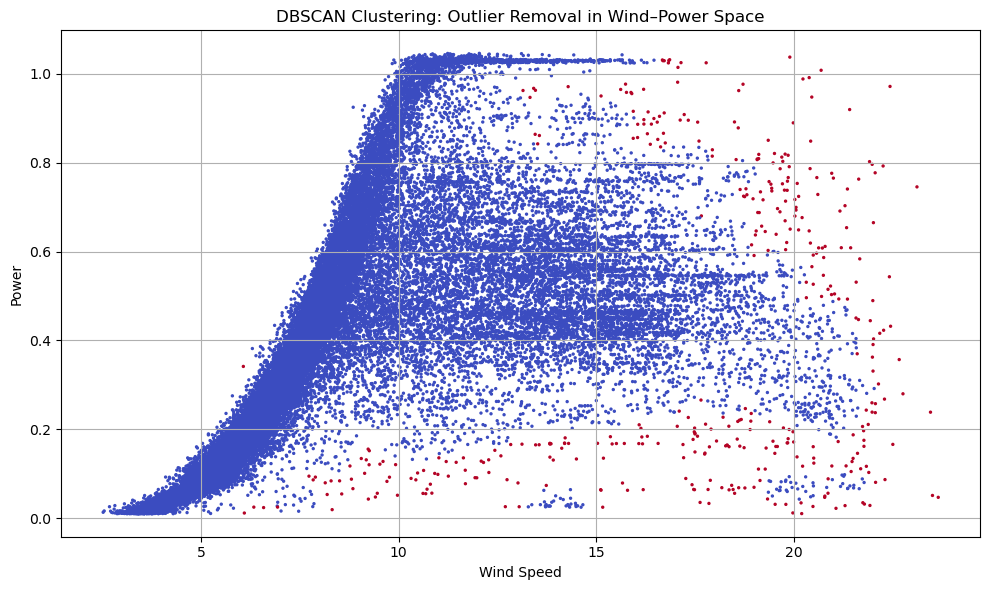

Cleaned data shape: (41178, 4)


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Use only wind_speed and power
df_dbscan = df_selected[['wind_speed', 'power']].copy()

# Normalize features for DBSCAN (important for Euclidean distance-based clustering)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_dbscan)

# Apply DBSCAN
db = DBSCAN(eps=0.1, min_samples=10)
labels = db.fit_predict(data_scaled)

# Add cluster labels to df_selected (NOT df_dbscan, to preserve full original context)
df_selected['dbscan_label'] = labels

# Filter out noise points (label = -1)
df_cleaned = df_selected[df_selected['dbscan_label'] != -1].copy()

# Visualize: noise = red (label -1), others = blue
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['wind_speed'], df_selected['power'], 
            c=(df_selected['dbscan_label'] == -1), cmap='coolwarm', s=2)
plt.xlabel("Wind Speed")
plt.ylabel("Power")
plt.title("DBSCAN Clustering: Outlier Removal in Wind–Power Space")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display cleaned data size
print("Cleaned data shape:", df_cleaned.shape)


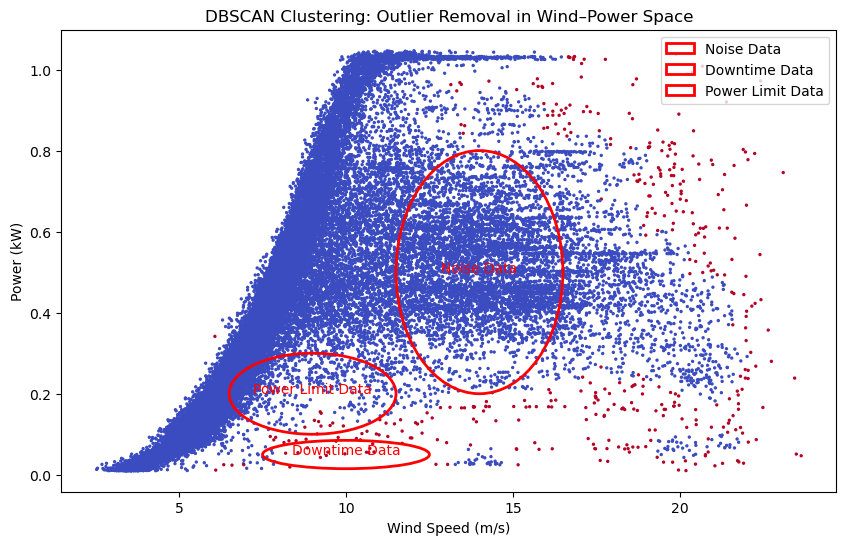

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all data, coloring noise points red
ax.scatter(df_selected['wind_speed'], df_selected['power'], 
           c=(df_selected['dbscan_label'] == -1), cmap='coolwarm', s=2)

# Add ellipses manually 
from matplotlib.patches import Ellipse

noise_ellipse = Ellipse(xy=(14, 0.5), width=5, height=0.6, edgecolor='red', fc='None', lw=2, label='Noise Data')
downtime_ellipse = Ellipse(xy=(10, 0.05), width=5, height=0.07, edgecolor='red', fc='None', lw=2, label='Downtime Data')
limit_ellipse = Ellipse(xy=(9, 0.2), width=5, height=0.2, edgecolor='red', fc='None', lw=2, label='Power Limit Data')

for ellipse, label in zip([noise_ellipse, downtime_ellipse, limit_ellipse],
                          ['Noise Data', 'Downtime Data', 'Power Limit Data']):
    ax.add_patch(ellipse)
    ax.text(ellipse.center[0], ellipse.center[1], label, color='red', fontsize=10, ha='center')

ax.set_title("DBSCAN Clustering: Outlier Removal in Wind–Power Space")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.legend(loc='upper right')
plt.show()




### Visualization of Operational Data and Power Partitioning

To better understand the turbine's operational characteristics and identify noise-prone areas, we visualize the cleaned SCADA data from Wind Farm C using three approaches:

#### (a) Scatter Plot with Abnormal Regions Highlighted

A scatter plot of wind speed vs. power output was created using the cleaned data. Three key regions of abnormal behavior were highlighted using **manual ellipses**:

* **Noise Data**: Outliers beyond expected physical behavior.
* **Downtime Data**: Low wind, low power scenarios indicating potential standstill.
* **Power Limit Data**: Saturated regions where turbines may be throttling due to system limits.

These visual cues help identify operational outliers that were filtered using DBSCAN.

#### (b) Density-Based Scatter Plot

To better understand the distribution of operational states, we overlay a **kernel density estimate (KDE)** on the wind–power space. This highlights zones of **high-density normal behavior**, helping visualize the turbine's typical response to different wind speeds.

#### (c) Power Partition Visualization

For power curve modeling, we **partition the cleaned data** by power bins with a width of 0.05 as power ranges from 0
to approximately 1.05. Each bin represents a discrete operational zone, allowing us to:

* Compute average wind speed and power per bin
* Fit a piecewise ideal power curve later
  This step lays the foundation for modeling "healthy" turbine performance using cubic regression and 3σ bounds.

These visualizations together inform both our **data filtering** and **feature engineering** strategies.


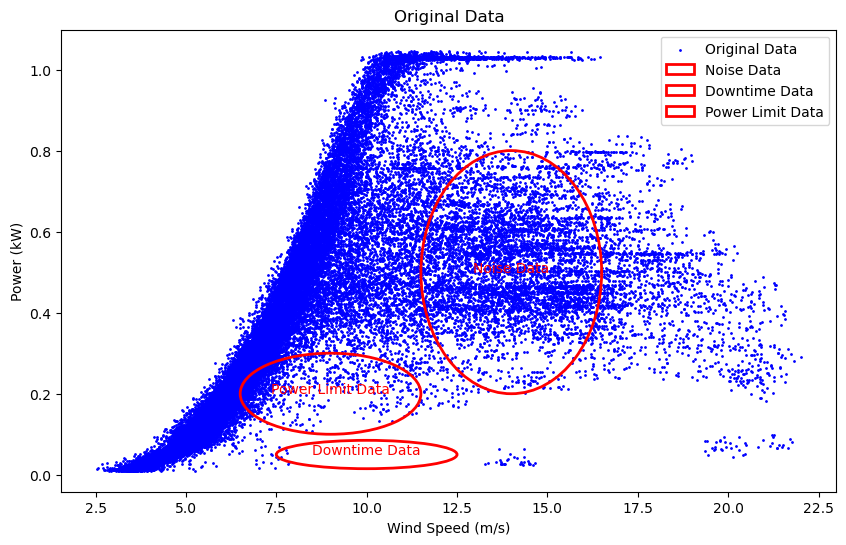

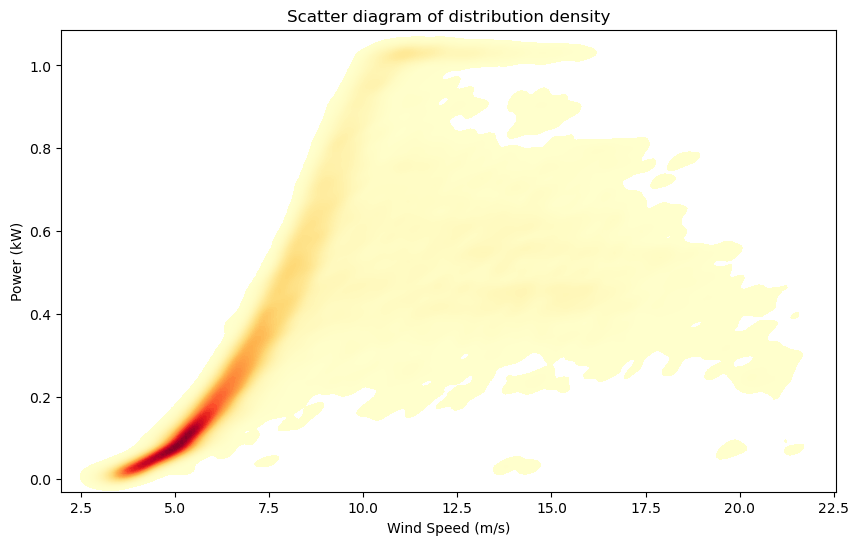

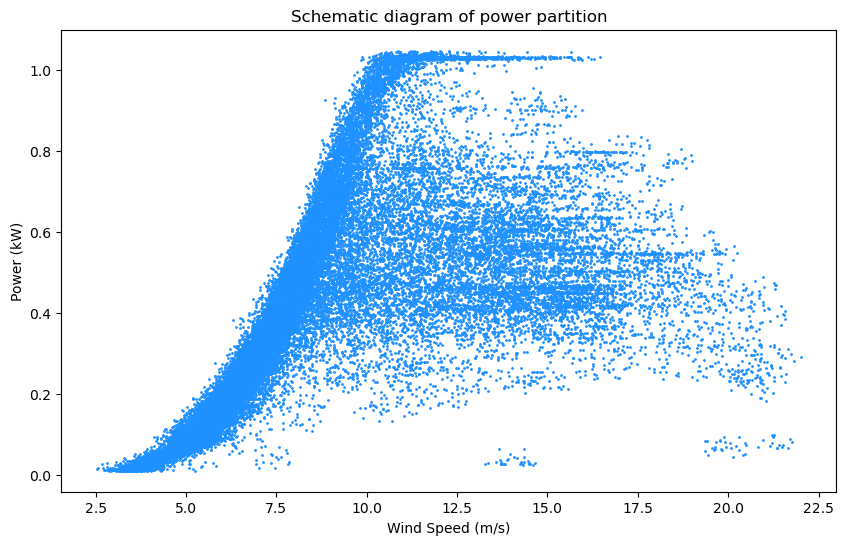

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# References : https://ieeexplore.ieee.org/document/9530585

# Step 1: (a) Scatter plot with highlighted abnormal regions
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=1, c='blue', label='Original Data')

# Add ellipses manually 
from matplotlib.patches import Ellipse

noise_ellipse = Ellipse(xy=(14, 0.5), width=5, height=0.6, edgecolor='red', fc='None', lw=2, label='Noise Data')
downtime_ellipse = Ellipse(xy=(10, 0.05), width=5, height=0.07, edgecolor='red', fc='None', lw=2, label='Downtime Data')
limit_ellipse = Ellipse(xy=(9, 0.2), width=5, height=0.2, edgecolor='red', fc='None', lw=2, label='Power Limit Data')

for ellipse, label in zip([noise_ellipse, downtime_ellipse, limit_ellipse],
                          ['Noise Data', 'Downtime Data', 'Power Limit Data']):
    ax.add_patch(ellipse)
    ax.text(ellipse.center[0], ellipse.center[1], label, color='red', fontsize=10, ha='center')

ax.set_title("Original Data")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.legend(loc='upper right')
plt.show()

# Step 2: (b) Density-based scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(
    x=df_cleaned['wind_speed'], 
    y=df_cleaned['power'], 
    cmap="YlOrRd", fill=True, bw_adjust=0.3, ax=ax, levels=100, thresh=0.01
)
ax.set_title("Scatter diagram of distribution density")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
plt.show()

# Step 3: Power partition visualization
bin_width = 0.05  
df_cleaned['power_bin'] = (df_cleaned['power'] // bin_width) * bin_width

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=1, c='dodgerblue')
ax.set_title("Schematic diagram of power partition")
ax.set_xlabel("Wind Speed (m/s)")
ax.set_ylabel("Power (kW)")
plt.show()



### Identification and Visualization of Downtime Cluster

In wind turbine SCADA data, **downtime regions** are typically characterized by low wind speeds and near-zero power output. These periods may indicate turbine shutdown, curtailment, or maintenance events. To explicitly identify such instances:

* A **bounding box** was defined in the wind–power space to isolate potential downtime points.

  * Wind speed range: 7–11 m/s
  * Power output range: 0–0.1 
* Data points within this region were extracted and counted.
* The proportion of such points relative to the total cleaned dataset was computed to quantify the frequency of downtime-like behavior.

To support visual inspection:

* The entire dataset was plotted with **low-opacity blue points**.
* **Downtime points** were overlaid in red for contrast.
* A **rectangle** was drawn around the downtime region to clearly demarcate the cluster.

This analysis helps assess turbine operational consistency and is useful in refining the health dataset for subsequent modeling.



Number of points in downtime cluster region: 19
Percentage of downtime points in dataset: 0.05%


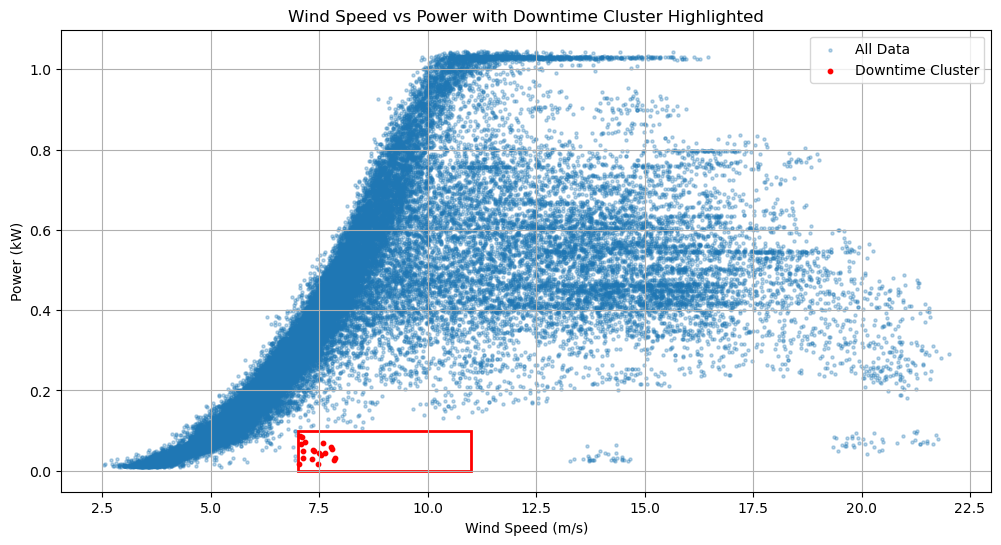

In [16]:
import matplotlib.patches as patches


downtime_x_min, downtime_x_max = 7, 11  # Wind Speed range (m/s)
downtime_y_min, downtime_y_max = 0, 0.1  # Power range (kW)

# Filter points in downtime region
downtime_points = df_cleaned[
    (df_cleaned['wind_speed'] >= downtime_x_min) & (df_cleaned['wind_speed'] <= downtime_x_max) &
    (df_cleaned['power'] >= downtime_y_min) & (df_cleaned['power'] <= downtime_y_max)
]

print(f"Number of points in downtime cluster region: {len(downtime_points)}")
print(f"Percentage of downtime points in dataset: {len(downtime_points)/len(df_cleaned)*100:.2f}%")

# Optional: plot again highlighting downtime points
plt.figure(figsize=(12, 6))
plt.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=5, label='All Data', alpha=0.3)
plt.scatter(downtime_points['wind_speed'], downtime_points['power'], color='red', s=10, label='Downtime Cluster')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Wind Speed vs Power with Downtime Cluster Highlighted')
plt.legend()
plt.grid(True)

# Draw rectangle around downtime region for clarity
ax = plt.gca()
rect = patches.Rectangle((downtime_x_min, downtime_y_min), downtime_x_max - downtime_x_min, downtime_y_max - downtime_y_min, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()




###  Fitting a Piecewise Ideal Power Curve

To accurately characterize the expected behavior of a healthy wind turbine, we fit an **ideal power curve** to the SCADA data. The power curve approximates the relationship between wind speed and power output under normal conditions.

#### Procedure:

* **Data Binning**: The cleaned data was grouped into discrete bins based on power values (`power_bin`) (ranging from 0
to approximately 1.05), with mean and standard deviation of wind speed, and mean power, computed per bin.
* **Rising Segment Fit**: For the **rising section** of the power curve (wind speeds up to 13 m/s), a **cubic polynomial** was fitted to the bin-aggregated midpoints.
* **Constant Cap**: Beyond 13 m/s, power generation typically plateaus. Hence, a **constant power cap** was defined equal to the cubic curve value at 13 m/s.
* **Piecewise Curve Construction**: A piecewise function was constructed combining the cubic segment and the constant cap, resulting in a realistic ideal curve.

#### Visualization:

* The cleaned wind–power data is shown as a scatter plot.
* The **fitted piecewise curve** is overlaid in green, clearly capturing the cubic rise and capped behavior typical of wind turbine power curves.

This fitted curve serves as a foundation for defining **normal operational bounds** (e.g., ±3σ envelopes) in later stages of anomaly detection.



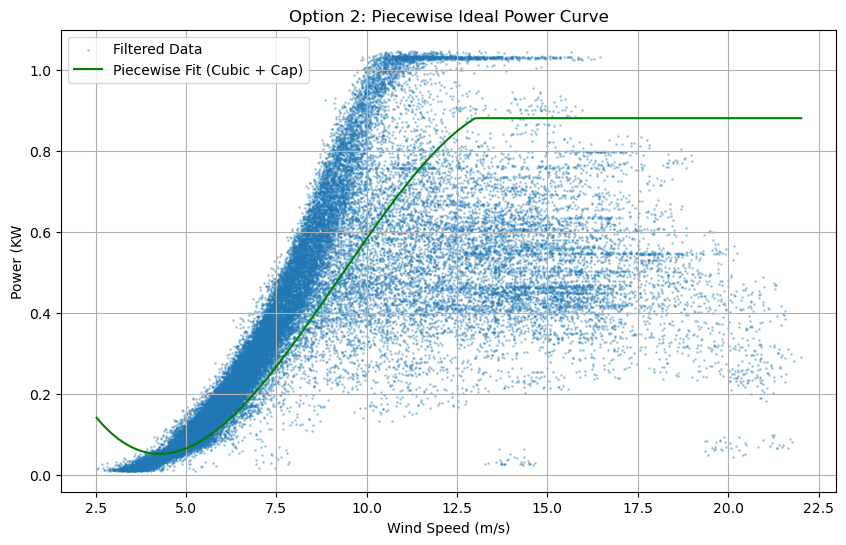

In [17]:

midpoints = df_cleaned.groupby('power_bin').agg({
    'wind_speed': ['mean', 'std'],
    'power': 'mean'
}).dropna().reset_index()

# Flatten column names
midpoints.columns = ['power_bin', 'wind_speed_mean', 'wind_speed_std', 'power_mean']

cutoff_speed = 13
mid_rising = midpoints[midpoints['wind_speed_mean'] <= cutoff_speed]


coeffs_opt2 = np.polyfit(mid_rising['wind_speed_mean'], mid_rising['power_mean'], deg=3)
poly_opt2 = np.poly1d(coeffs_opt2)


cap_value = poly_opt2(cutoff_speed)


wind_range = np.linspace(df_cleaned['wind_speed'].min(), df_cleaned['wind_speed'].max(), 500)
fitted_power_opt2 = np.piecewise(
    wind_range,
    [wind_range <= cutoff_speed, wind_range > cutoff_speed],
    [lambda x: poly_opt2(x), lambda x: cap_value]
)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=1, alpha=0.3, label='Filtered Data')
plt.plot(wind_range, fitted_power_opt2, color='green', label='Piecewise Fit (Cubic + Cap)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (KW')
plt.title('Option 2: Piecewise Ideal Power Curve')
plt.legend()
plt.grid(True)
plt.show()



###  3σ Filtering Around Ideal Power Curve

To ensure only high-quality, healthy operational data is used for model training, we define a **tolerance band** around the fitted ideal power curve using the **3-sigma rule**:

#### Procedure:

1. **Compute Standard Deviation**:
   From the binned power data, the **average standard deviation of wind speed** is calculated. This value, `σ`, represents natural variability in wind speed within each power bin.

2. **Ideal Power Prediction**:
   Using the previously fitted **piecewise power curve**, we predict the **ideal power output** for each wind speed value in the dataset.

3. **Construct Upper/Lower Bounds**:
   We then generate a **3-sigma band** by shifting wind speed by ±3σ and passing those values through the ideal power curve to compute the corresponding **upper and lower power limits**.

4. **Filter Based on Boundaries**:
   Any data point whose actual power lies **within the predicted 3σ power bounds** is retained. Others are excluded as potential anomalies or outliers.

This filtering step ensures that the final healthy dataset (`df_final_health`) includes only consistent operational behavior, free of abnormal patterns or measurement noise. The result is a robust dataset ideal for training fault detection models.




In [18]:

sigma = midpoints['wind_speed_std'].mean()

# Step 2: Predict ideal power using Option 2’s piecewise function
def piecewise_ideal(x):
    return np.where(x <= cutoff_speed, poly_opt2(x), cap_value)

df_cleaned['ideal_power'] = piecewise_ideal(df_cleaned['wind_speed'])

# Step 3: Compute upper/lower bounds using 3-sigma rule
df_cleaned['ideal_upper'] = piecewise_ideal(df_cleaned['wind_speed'] + 3 * sigma)
df_cleaned['ideal_lower'] = piecewise_ideal(df_cleaned['wind_speed'] - 3 * sigma)

# Step 4: Filter points within normal band
condition = (
    (df_cleaned['power'] >= df_cleaned['ideal_lower']) &
    (df_cleaned['power'] <= df_cleaned['ideal_upper'])
)

df_final_health = df_cleaned[condition].copy()
print("Final cleaned (3σ filtered) sample count:", df_final_health.shape[0])


Final cleaned (3σ filtered) sample count: 17373


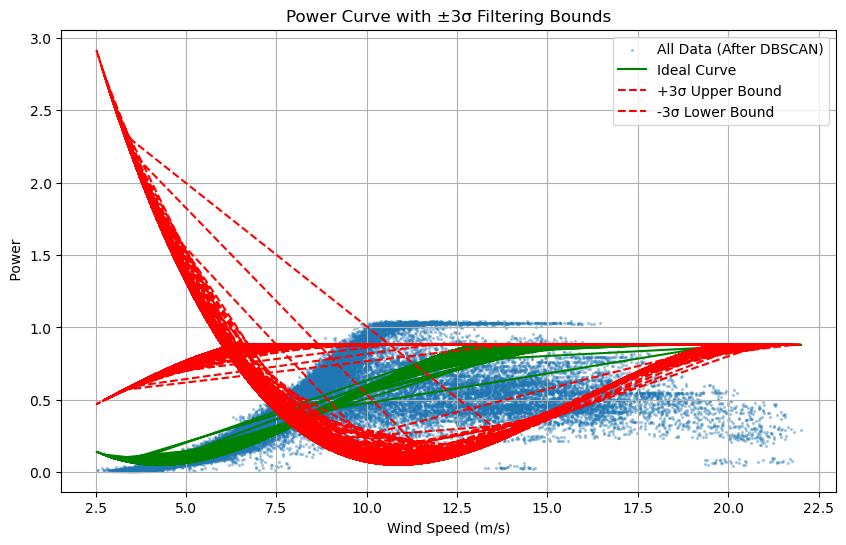

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['wind_speed'], df_cleaned['power'], s=2, alpha=0.3, label='All Data (After DBSCAN)')
plt.plot(df_cleaned['wind_speed'], df_cleaned['ideal_power'], color='green', label='Ideal Curve')
plt.plot(df_cleaned['wind_speed'], df_cleaned['ideal_upper'], color='red', linestyle='--', label='+3σ Upper Bound')
plt.plot(df_cleaned['wind_speed'], df_cleaned['ideal_lower'], color='red', linestyle='--', label='-3σ Lower Bound')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel(" Power")
plt.title("Power Curve with ±3σ Filtering Bounds")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Step 1: Get sigma in wind speed domain (same as before)
sigma = midpoints['wind_speed_std'].mean()

# Step 2: Predict ideal power once
df_cleaned['ideal_power'] = piecewise_ideal(df_cleaned['wind_speed'])

# Step 3: Compute residuals between actual and ideal
df_cleaned['residual'] = df_cleaned['power'] - df_cleaned['ideal_power']

# Step 4: Compute standard deviation of residuals (i.e., how power deviates from the curve)
residual_std = df_cleaned['residual'].std()

# Step 5: Use that to define fixed upper/lower bounds around ideal_power
df_cleaned['ideal_upper'] = df_cleaned['ideal_power'] + 3 * residual_std
df_cleaned['ideal_lower'] = df_cleaned['ideal_power'] - 3 * residual_std

# Step 6: Apply filtering
condition = (
    (df_cleaned['power'] >= df_cleaned['ideal_lower']) &
    (df_cleaned['power'] <= df_cleaned['ideal_upper'])
)

df_final_health = df_cleaned[condition].copy()
print("Final cleaned (residual-based 3σ) sample count:", df_final_health.shape[0])


Final cleaned (residual-based 3σ) sample count: 40959


In [21]:
df_final_health.shape

(40959, 9)

In [22]:
# Step 1: Ensure timestamps are in datetime format
df_final_health['time'] = pd.to_datetime(df_final_health['time'])
df_train['timestamp'] = pd.to_datetime(df_train['time_stamp'])

# Step 2: Merge on timestamp (and optionally asset_id if multiple turbines)
df_full_health = pd.merge(
    df_final_health[['time']],           # Only need time to join
    df_train,                        # Contains full features
    left_on='time',
    right_on='time_stamp',
    how='inner'                          # Only keep matching timestamps
)

# Step 3: Drop duplicate or redundant columns
df_full_health = df_full_health.drop(columns=['time_stamp'])

# Optional: Reset index
df_full_health.reset_index(drop=True, inplace=True)

# Final shape
print("Full health dataset shape:", df_full_health.shape)
df_full_health.head()


Full health dataset shape: (40959, 959)


,time,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_0_max,sensor_0_min,sensor_0_std,sensor_1_avg,...,wind_speed_235_avg,wind_speed_235_max,wind_speed_235_min,wind_speed_235_std,wind_speed_237_avg,wind_speed_237_max,wind_speed_237_min,wind_speed_237_std,label,timestamp
0,2022-12-22 15:00:00,21,0,train,0,8.794,15.9,3.9,2.157,-0.0255,...,5.129,8.4,2.1,0.9977,5.132,8.6,0.6,1.079,0,2022-12-22 15:00:00
1,2022-12-22 15:10:00,21,1,train,0,10.035,14.0,5.5,1.876,0.0196,...,5.403,8.7,1.8,1.0870,5.359,9.3,1.0,1.080,0,2022-12-22 15:10:00
2,2022-12-22 15:20:00,21,2,train,0,12.419,18.8,6.8,2.282,-0.0015,...,5.510,9.0,1.8,0.9002,5.611,8.8,0.8,1.067,0,2022-12-22 15:20:00
3,2022-12-22 15:30:00,21,3,train,0,12.512,16.2,7.8,1.445,0.0095,...,5.640,9.3,2.4,0.9638,5.650,9.1,1.3,1.031,0,2022-12-22 15:30:00
4,2022-12-22 15:40:00,21,4,train,0,13.386,17.5,9.4,1.666,0.0025,...,5.582,9.0,1.6,0.9208,5.892,9.9,2.2,1.014,0,2022-12-22 15:40:00


In [23]:

metadata_cols = ['time_stamp', 'asset_id','id','status_type_id', 'train_test','label']  # Adjust as needed
df_train_metadata = df_train[metadata_cols] if all(col in df_train.columns for col in metadata_cols) else pd.DataFrame()
df_test_metadata = df_test[metadata_cols] if all(col in df_test.columns for col in metadata_cols) else pd.DataFrame()

In [24]:
import pandas as pd

# Step 0: Define metadata columns
metadata_cols = ['id','time_stamp', 'asset_id', 'status_type_id', 'train_test', 'label']

# Step 1: Separate sensor columns from training set
sensor_cols_train = [col for col in df_full_health.columns if col not in metadata_cols]

# Step 2: Calculate % of zeros per column
zero_pct_train = (df_full_health[sensor_cols_train] == 0).sum() / len(df_full_health) * 100

# Step 3: Drop columns with ≥ 80% zeros from both train and test
cols_to_drop = zero_pct_train[zero_pct_train >= 80].index.tolist()

df_train_sensors_reduced = df_full_health.drop(columns=cols_to_drop)
df_test_sensors_reduced = df_test.drop(columns=cols_to_drop, errors='ignore')  # safely drops even if missing

# ✅ Final check
print("Train shape:", df_train_sensors_reduced.shape)
print("Test shape:", df_test_sensors_reduced.shape)


Train shape: (40959, 912)
Test shape: (1865, 911)


In [25]:
# Get column sets
train_cols = set(df_train_sensors_reduced.columns)
test_cols = set(df_test_sensors_reduced.columns)

# Compare
print("✅ Columns in train but not in test:")
print(train_cols - test_cols)

print("\n✅ Columns in test but not in train:")
print(test_cols - train_cols)


✅ Columns in train but not in test:
{'time', 'timestamp'}

✅ Columns in test but not in train:
{'time_stamp'}


In [26]:
df_test_sensors_reduced.columns

Index(['time_stamp', 'asset_id', 'id', 'train_test', 'status_type_id',
       'sensor_0_avg', 'sensor_0_max', 'sensor_0_min', 'sensor_0_std',
       'sensor_1_avg',
       ...
       'wind_speed_236_std', 'wind_speed_235_avg', 'wind_speed_235_max',
       'wind_speed_235_min', 'wind_speed_235_std', 'wind_speed_237_avg',
       'wind_speed_237_max', 'wind_speed_237_min', 'wind_speed_237_std',
       'label'],
      dtype='object', length=911)

In [27]:
# Step 1: Rename 'timestamp' or 'time' to 'time_stamp' in both DataFrames
for df in [df_train_sensors_reduced, df_test_sensors_reduced]:
    if 'timestamp' in df.columns:
        df.rename(columns={'timestamp': 'time_stamp'}, inplace=True)
    if 'time' in df.columns:
        df.rename(columns={'time': 'time_stamp'}, inplace=True)

# Step 2: Drop duplicate or unnecessary time columns (if any)
for df in [df_train_sensors_reduced, df_test_sensors_reduced]:
    # Drop any remaining time-related columns that are not 'time_stamp'
    for col in ['timestamp', 'time']:
        if col in df.columns:
            df.drop(columns=col, inplace=True)

# ✅ Confirm
print("Train columns:", df_train_sensors_reduced.columns)
print("Test columns:", df_test_sensors_reduced.columns)


Train columns: Index(['time_stamp', 'asset_id', 'id', 'train_test', 'status_type_id',
       'sensor_0_avg', 'sensor_0_max', 'sensor_0_min', 'sensor_0_std',
       'sensor_1_avg',
       ...
       'wind_speed_235_avg', 'wind_speed_235_max', 'wind_speed_235_min',
       'wind_speed_235_std', 'wind_speed_237_avg', 'wind_speed_237_max',
       'wind_speed_237_min', 'wind_speed_237_std', 'label', 'time_stamp'],
      dtype='object', length=912)
Test columns: Index(['time_stamp', 'asset_id', 'id', 'train_test', 'status_type_id',
       'sensor_0_avg', 'sensor_0_max', 'sensor_0_min', 'sensor_0_std',
       'sensor_1_avg',
       ...
       'wind_speed_236_std', 'wind_speed_235_avg', 'wind_speed_235_max',
       'wind_speed_235_min', 'wind_speed_235_std', 'wind_speed_237_avg',
       'wind_speed_237_max', 'wind_speed_237_min', 'wind_speed_237_std',
       'label'],
      dtype='object', length=911)


In [28]:
df_features = pd.read_csv("feature_description.csv", sep=";")
counter_features = df_features[df_features['is_counter'] == True]['sensor_name'].tolist()

# Drop counter features from train
df_train_sensors = df_train_sensors_reduced.drop(columns=[c for c in counter_features if c in df_train_sensors_reduced.columns])

# Drop the **same columns** from test (only those present)
df_test_sensors = df_test_sensors_reduced.drop(columns=[c for c in counter_features if c in df_test_sensors_reduced.columns])

print(df_train_sensors.shape)
print(df_test_sensors.shape)


(40959, 912)
(1865, 911)


In [29]:
# Get column sets
train_cols = set(df_train_sensors.columns)
test_cols = set(df_test_sensors.columns)

# Compare
print("✅ Columns in train but not in test:")
print(train_cols - test_cols)

print("\n✅ Columns in test but not in train:")
print(test_cols - train_cols)


✅ Columns in train but not in test:
set()

✅ Columns in test but not in train:
set()


In [30]:
df_test_sensors = df_test_sensors[df_train_sensors.columns]


In [31]:
df_train_sensors.shape

(40959, 912)

In [32]:
df_test_sensors.shape

(1865, 912)



###  Feature Categorization Based on Descriptions

To better manage the large number of sensor variables in the SCADA dataset, we categorize features based on their physical meaning and sensor descriptions provided in the metadata file `feature_description.csv`.

#### Method:

* Sensor descriptions are converted to lowercase for **case-insensitive matching**.
* A **keyword-based filtering function** scans each description for relevant terms to assign sensors to categories.
* Categories include:

  * **Power features** (e.g., current, voltage, power consumption)
  * **Wind features** (e.g., wind speed, direction)
  * **Temperature features** (e.g., bearing, oil, generator temps)
  * **Vibration features**
  * **Pitch and angle-related sensors**
  * **Hydraulic and cooling system sensors**
  * **Motor current and yaw motor features**
  * **Counters and other miscellaneous features**

#### Outcome:

Each sensor is assigned to exactly one or more categories, depending on its description and flag columns like `is_counter` and `is_angle`. Sensors not matched to any specific category are grouped under `other_features`.

This modular organization simplifies:

* Feature selection
* Redundancy analysis
* Interpretation during anomaly detection




In [33]:
import pandas as pd

# Load feature description CSV
df_features = pd.read_csv('feature_description.csv', sep = ";")

# Lowercase descriptions for case-insensitive matching
df_features['desc_lower'] = df_features['description'].str.lower()

# Helper function to filter sensor_names by keywords in description
def filter_by_keywords(keywords, df):
    mask = df['desc_lower'].apply(lambda x: any(kw in x for kw in keywords))
    return df.loc[mask, 'sensor_name'].tolist()

# Build dictionary with categories and sensor lists
feature_categories = {}

feature_categories['power_features'] = filter_by_keywords(
    ['power', 'current', 'voltage', 'consumption', 'active power', 'reactive power', 'rms current', 'rms voltage'], df_features
)

feature_categories['wind_features'] = filter_by_keywords(
    ['wind speed', 'wind direction', 'relative wind'], df_features
)

feature_categories['temperature_features'] = filter_by_keywords(
    ['temperature', 'temp', 'cooling', 'oil temperature', 'generator temperature', 'ambient temperature', 'bearing temperature'], df_features
)

feature_categories['vibration_features'] = filter_by_keywords(
    ['vibration'], df_features
)

feature_categories['pitch_features'] = filter_by_keywords(
    ['pitch angle', 'pitch'], df_features
)

feature_categories['counter_features'] = df_features[df_features['is_counter'] == True]['sensor_name'].tolist()

feature_categories['angle_features'] = df_features[df_features['is_angle'] == True]['sensor_name'].tolist()

feature_categories['hydraulic_features'] = filter_by_keywords(
    ['hydraulic', 'pressure', 'flow', 'oil level', 'oil pressure'], df_features
)

feature_categories['cooling_features'] = filter_by_keywords(
    ['cooling', 'cooler', 'fan speed', 'water temperature', 'water flow', 'water pressure'], df_features
)

feature_categories['motor_current_features'] = filter_by_keywords(
    ['motor current'], df_features
)

feature_categories['yaw_motor_features'] = filter_by_keywords(
    ['yaw motor'], df_features
)

feature_categories['other_features'] = [s for s in df_features['sensor_name'].tolist() if s not in sum(feature_categories.values(), [])]

# Optional: print count of sensors in each category
for cat, sensors in feature_categories.items():
    print(f"{cat}: {len(sensors)} sensors")

# Example access
# print(feature_categories['power_features'])

power_features: 82 sensors
wind_features: 7 sensors
temperature_features: 79 sensors
vibration_features: 4 sensors
pitch_features: 2 sensors
counter_features: 0 sensors
angle_features: 12 sensors
hydraulic_features: 35 sensors
cooling_features: 31 sensors
motor_current_features: 13 sensors
yaw_motor_features: 8 sensors
other_features: 31 sensors


In [34]:
# List of common suffixes in your sensor dataframe columns
stats_suffixes = ['_avg', '_max', '_min', '_std']

def expand_sensors_with_suffixes(sensor_list, df_columns, suffixes):
    expanded_cols = []
    for sensor in sensor_list:
        for suffix in suffixes:
            col_name = f"{sensor}{suffix}"
            if col_name in df_columns:
                expanded_cols.append(col_name)
    return expanded_cols

# For training data
df_train_columns = df_train_sensors.columns.tolist()
feature_categories_expanded_train = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_train_columns, stats_suffixes)
    feature_categories_expanded_train[category] = expanded_cols
    print(f"[Train] {category}: {len(expanded_cols)} columns")

# For test data
df_test_columns = df_test_sensors.columns.tolist()
feature_categories_expanded_test = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_test_columns, stats_suffixes)
    feature_categories_expanded_test[category] = expanded_cols
    print(f"[Test] {category}: {len(expanded_cols)} columns")


[Train] power_features: 301 columns
[Train] wind_features: 28 columns
[Train] temperature_features: 316 columns
[Train] vibration_features: 16 columns
[Train] pitch_features: 8 columns
[Train] counter_features: 0 columns
[Train] angle_features: 47 columns
[Train] hydraulic_features: 131 columns
[Train] cooling_features: 120 columns
[Train] motor_current_features: 43 columns
[Train] yaw_motor_features: 24 columns
[Train] other_features: 105 columns
[Test] power_features: 301 columns
[Test] wind_features: 28 columns
[Test] temperature_features: 316 columns
[Test] vibration_features: 16 columns
[Test] pitch_features: 8 columns
[Test] counter_features: 0 columns
[Test] angle_features: 47 columns
[Test] hydraulic_features: 131 columns
[Test] cooling_features: 120 columns
[Test] motor_current_features: 43 columns
[Test] yaw_motor_features: 24 columns
[Test] other_features: 105 columns


In [35]:

import pandas as pd
import numpy as np



def find_high_corr_features(df_subset, threshold=0.9):
    corr_matrix = df_subset.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    high_corr_pairs = []
    for col in upper.columns:
        for row in upper.index:
            corr_val = upper.loc[row, col]
            if pd.notna(corr_val) and corr_val > threshold:
                high_corr_pairs.append((row, col, corr_val))
    return high_corr_pairs

correlation_threshold = 0.9

for category, columns in feature_categories_expanded_train.items():
    cols_in_df = [c for c in columns if c in df_train_sensors.columns]
    
    print(f"\n--- Correlation analysis for category: {category} ---")
    
    if len(cols_in_df) < 2:
        print(f"Not enough columns to compute correlation (found {len(cols_in_df)}). Skipping.")
        continue
    
    df_subset = df_train_sensors[cols_in_df]
    high_corr_pairs = find_high_corr_features(df_subset, threshold=correlation_threshold)
    
    if not high_corr_pairs:
        print(f"No pairs with correlation above {correlation_threshold} found.")
    else:
        print(f"Highly correlated pairs (abs(corr) > {correlation_threshold}):")
        for f1, f2, corr_val in high_corr_pairs:
            print(f"{f1} <--> {f2}: correlation = {corr_val:.3f}")



--- Correlation analysis for category: power_features ---
Highly correlated pairs (abs(corr) > 0.9):
power_2_avg <--> power_2_max: correlation = 0.964
power_2_avg <--> power_2_min: correlation = 0.957
sensor_4_avg <--> sensor_4_std: correlation = 0.929
power_2_avg <--> power_5_avg: correlation = 1.000
power_2_max <--> power_5_avg: correlation = 0.964
power_2_min <--> power_5_avg: correlation = 0.957
power_2_avg <--> power_5_max: correlation = 0.964
power_2_max <--> power_5_max: correlation = 1.000
power_5_avg <--> power_5_max: correlation = 0.964
power_2_avg <--> power_5_min: correlation = 0.956
power_2_min <--> power_5_min: correlation = 1.000
power_5_avg <--> power_5_min: correlation = 0.956
power_2_std <--> power_5_std: correlation = 0.999
power_2_avg <--> power_6_avg: correlation = 1.000
power_2_max <--> power_6_avg: correlation = 0.964
power_2_min <--> power_6_avg: correlation = 0.957
power_5_avg <--> power_6_avg: correlation = 1.000
power_5_max <--> power_6_avg: correlation = 0.

In [36]:
import numpy as np
import pandas as pd
import re
# Rename 'time' to 'time_stamp'
df_full_health = df_train_sensors.rename(columns={'time': 'time_stamp'})
df_test_labeled = df_test_sensors.rename(columns={'time': 'time_stamp'})

# Define base metadata columns
base_metadata_cols = ['id','time_stamp', 'asset_id', 'status_type_id', 'train_test']

# Include 'label' only if it exists in test set
metadata_cols_train = [col for col in base_metadata_cols if col in df_full_health.columns]
metadata_cols_test = base_metadata_cols + ['label'] if 'label' in df_test_labeled.columns else base_metadata_cols

# Separate sensor-only features
df_train_sensor_only = df_full_health.drop(columns=metadata_cols_train, errors='ignore')
df_test_sensor_only = df_test_labeled.drop(columns=metadata_cols_test, errors='ignore')

# --- Correlation and drop logic ---
def feature_priority(feature_name):
    feature_name = feature_name.lower()
    if feature_name == "power_2_avg":
        return 0
    if feature_name == "power_2_std":
        return 1
    elif re.search(r'(_avg| average)$', feature_name):
        return 2
    elif re.search(r'(_std| stddev| standard deviation)$', feature_name):
        return 3
    elif re.search(r'(_min|min)$', feature_name):
        return 4
    elif re.search(r'(_max|max)$', feature_name):
        return 5
    else:
        return 6

def get_high_correlation_pairs(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    high_corr_pairs = {}
    for col1 in upper.columns:
        for col2 in upper.index:
            if pd.notna(upper.loc[col2, col1]) and upper.loc[col2, col1] > threshold:
                key = tuple(sorted((col1, col2)))
                if key not in high_corr_pairs:
                    high_corr_pairs[key] = upper.loc[col2, col1]
    return high_corr_pairs

def drop_features_by_priority(high_corr_pairs):
    to_drop = set()
    for (f1, f2), _ in high_corr_pairs.items():
        if f1 in to_drop or f2 in to_drop:
            continue
        if feature_priority(f1) < feature_priority(f2):
            to_drop.add(f2)
        else:
            to_drop.add(f1)
    return to_drop

# Apply correlation filtering
high_corr_overall = get_high_correlation_pairs(df_train_sensor_only, threshold=0.9)
features_to_drop = drop_features_by_priority(high_corr_overall)

# Drop selected features and reattach metadata
df_train_sensors_reduced = pd.concat([
    df_train_sensor_only.drop(columns=[f for f in features_to_drop if f in df_train_sensor_only.columns]),
    df_full_health[metadata_cols_train]
], axis=1)

df_test_sensors_reduced = pd.concat([
    df_test_sensor_only.drop(columns=[f for f in features_to_drop if f in df_test_sensor_only.columns]),
    df_test_labeled[metadata_cols_test]
], axis=1)

# Final checks
print(f" Train shape: {df_train_sensors_reduced.shape}")
print(f" Test shape: {df_test_sensors_reduced.shape}")
if 'label' in df_test_sensors_reduced.columns:
    print(f" Test label distribution:\n{df_test_sensors_reduced['label'].value_counts()}")


 Train shape: (40959, 282)
 Test shape: (1865, 282)
 Test label distribution:
label
0    1577
1     288
Name: count, dtype: int64


In [37]:
import pandas as pd

# Load feature description CSV
df_features = pd.read_csv('feature_description.csv', sep = ";")

# Lowercase descriptions for case-insensitive matching
df_features['desc_lower'] = df_features['description'].str.lower()

# Helper function to filter sensor_names by keywords in description
def filter_by_keywords(keywords, df):
    mask = df['desc_lower'].apply(lambda x: any(kw in x for kw in keywords))
    return df.loc[mask, 'sensor_name'].tolist()

# Build dictionary with categories and sensor lists
feature_categories = {}

feature_categories['power_features'] = filter_by_keywords(
    ['power', 'current', 'voltage', 'consumption', 'active power', 'reactive power', 'rms current', 'rms voltage'], df_features
)

feature_categories['wind_features'] = filter_by_keywords(
    ['wind speed', 'wind direction', 'relative wind'], df_features
)

feature_categories['temperature_features'] = filter_by_keywords(
    ['temperature', 'temp', 'cooling', 'oil temperature', 'generator temperature', 'ambient temperature', 'bearing temperature'], df_features
)

feature_categories['vibration_features'] = filter_by_keywords(
    ['vibration'], df_features
)

feature_categories['pitch_features'] = filter_by_keywords(
    ['pitch angle', 'pitch'], df_features
)

feature_categories['counter_features'] = df_features[df_features['is_counter'] == True]['sensor_name'].tolist()

feature_categories['angle_features'] = df_features[df_features['is_angle'] == True]['sensor_name'].tolist()

feature_categories['hydraulic_features'] = filter_by_keywords(
    ['hydraulic', 'pressure', 'flow', 'oil level', 'oil pressure'], df_features
)

feature_categories['cooling_features'] = filter_by_keywords(
    ['cooling', 'cooler', 'fan speed', 'water temperature', 'water flow', 'water pressure'], df_features
)

feature_categories['motor_current_features'] = filter_by_keywords(
    ['motor current'], df_features
)

feature_categories['yaw_motor_features'] = filter_by_keywords(
    ['yaw motor'], df_features
)

feature_categories['generator_features'] = filter_by_keywords(
    [
    'generator', 'rotor', 'stator', 'bearing', 'rpm', 'temperature generator',
    'generator temperature', 'generator rms', 'generator acceleration'
], df_features
)

feature_categories['gearbox_features'] = filter_by_keywords(
    [
    'gearbox', 'gear', 'shaft', 'transmission', 'oil level', 'oil temperature',
    'gearbox oil', 'gearbox pressure', 'bypass valve gearbox'
], df_features
)



feature_categories['other_features'] = [s for s in df_features['sensor_name'].tolist() if s not in sum(feature_categories.values(), [])]

# Optional: print count of sensors in each category
for cat, sensors in feature_categories.items():
    print(f"{cat}: {len(sensors)} sensors")

# Example access
# print(feature_categories['power_features'])

power_features: 82 sensors
wind_features: 7 sensors
temperature_features: 79 sensors
vibration_features: 4 sensors
pitch_features: 2 sensors
counter_features: 0 sensors
angle_features: 12 sensors
hydraulic_features: 35 sensors
cooling_features: 31 sensors
motor_current_features: 13 sensors
yaw_motor_features: 8 sensors
generator_features: 65 sensors
gearbox_features: 20 sensors
other_features: 17 sensors


In [38]:
# List of common suffixes in your sensor dataframe columns
stats_suffixes = ['_avg', '_max', '_min', '_std']

def expand_sensors_with_suffixes(sensor_list, df_columns, suffixes):
    expanded_cols = []
    for sensor in sensor_list:
        for suffix in suffixes:
            col_name = f"{sensor}{suffix}"
            if col_name in df_columns:
                expanded_cols.append(col_name)
    return expanded_cols

# For training data
df_train_columns = df_train_sensors.columns.tolist()
feature_categories_expanded_train = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_train_columns, stats_suffixes)
    feature_categories_expanded_train[category] = expanded_cols
    print(f"[Train] {category}: {len(expanded_cols)} columns")

# For test data
df_test_columns = df_test_sensors.columns.tolist()
feature_categories_expanded_test = {}

for category, sensors in feature_categories.items():
    expanded_cols = expand_sensors_with_suffixes(sensors, df_test_columns, stats_suffixes)
    feature_categories_expanded_test[category] = expanded_cols
    print(f"[Test] {category}: {len(expanded_cols)} columns")


[Train] power_features: 301 columns
[Train] wind_features: 28 columns
[Train] temperature_features: 316 columns
[Train] vibration_features: 16 columns
[Train] pitch_features: 8 columns
[Train] counter_features: 0 columns
[Train] angle_features: 47 columns
[Train] hydraulic_features: 131 columns
[Train] cooling_features: 120 columns
[Train] motor_current_features: 43 columns
[Train] yaw_motor_features: 24 columns
[Train] generator_features: 260 columns
[Train] gearbox_features: 76 columns
[Train] other_features: 53 columns
[Test] power_features: 301 columns
[Test] wind_features: 28 columns
[Test] temperature_features: 316 columns
[Test] vibration_features: 16 columns
[Test] pitch_features: 8 columns
[Test] counter_features: 0 columns
[Test] angle_features: 47 columns
[Test] hydraulic_features: 131 columns
[Test] cooling_features: 120 columns
[Test] motor_current_features: 43 columns
[Test] yaw_motor_features: 24 columns
[Test] generator_features: 260 columns
[Test] gearbox_features: 76 

In [39]:


hydraulic_expanded_reduced = [col for col in feature_categories_expanded_train['hydraulic_features']
                              if col in df_train_sensors_reduced.columns]


temperature_expanded_reduced = [col for col in feature_categories_expanded_train['temperature_features']
                              if col in df_train_sensors_reduced.columns]

electrical_expanded_reduced = [col for col in feature_categories_expanded_train['power_features']
                              if col in df_train_sensors_reduced.columns]

vibration_expanded_reduced = [col for col in feature_categories_expanded_train['vibration_features']
                              if col in df_train_sensors_reduced.columns]

cooling_expanded_reduced = [col for col in feature_categories_expanded_train['cooling_features']
                              if col in df_train_sensors_reduced.columns]

generator_expanded_reduced = [col for col in feature_categories_expanded_train['generator_features']
                              if col in df_train_sensors_reduced.columns]

gearbox_expanded_reduced = [col for col in feature_categories_expanded_train['gearbox_features']
                            if col in df_train_sensors_reduced.columns]



In [40]:
hydraulic_features = [f for f in hydraulic_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
temperature_features = [f for f in temperature_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
electrical_features  = [f for f in electrical_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
vibration_features = [f for f in vibration_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
cooling_features = [f for f in cooling_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
generator_features = [f for f in generator_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]
gearbox_features = [f for f in gearbox_expanded_reduced if f in df_train_sensors_reduced.columns and f in df_test_sensors_reduced.columns]





In [41]:
# Define all your feature lists in a dictionary for convenience
feature_groups = {
    "hydraulic_features": hydraulic_features,
    "temperature_features": temperature_features,
    "electrical_features": electrical_features,
    "vibration_features": vibration_features,
    "cooling_features": cooling_features,
    "generator_features": generator_features,
    "gearbox_features": gearbox_features
}

# Check overlaps between every pair of groups
overlaps = {}

group_names = list(feature_groups.keys())

for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        g1 = group_names[i]
        g2 = group_names[j]
        set1 = set(feature_groups[g1])
        set2 = set(feature_groups[g2])
        common = set1.intersection(set2)
        if common:
            overlaps[(g1, g2)] = common

# Print overlaps
if overlaps:
    print("Features appearing in multiple sensor groups:")
    for groups, features in overlaps.items():
        print(f"{groups[0]} & {groups[1]}: {features}")
else:
    print("No overlapping features found between sensor groups.")


Features appearing in multiple sensor groups:
hydraulic_features & temperature_features: {'sensor_46_avg', 'sensor_179_std', 'sensor_178_std', 'sensor_232_max', 'sensor_46_std'}
hydraulic_features & cooling_features: {'sensor_226_max', 'sensor_46_avg', 'sensor_230_max', 'sensor_227_max', 'sensor_227_avg', 'sensor_227_min', 'sensor_232_max', 'sensor_46_std', 'sensor_43_max', 'sensor_43_std', 'sensor_227_std', 'sensor_226_avg', 'sensor_43_avg'}
hydraulic_features & generator_features: {'sensor_42_std', 'sensor_54_std', 'sensor_42_min', 'sensor_55_std', 'sensor_42_max', 'sensor_55_max', 'sensor_55_avg', 'sensor_43_max', 'sensor_43_std', 'sensor_54_max', 'sensor_42_avg', 'sensor_54_avg', 'sensor_43_avg'}
hydraulic_features & gearbox_features: {'sensor_94_std', 'sensor_94_min', 'sensor_118_std', 'sensor_94_avg'}
temperature_features & cooling_features: {'sensor_176_avg', 'sensor_173_min', 'sensor_46_avg', 'sensor_21_std', 'sensor_176_std', 'sensor_174_avg', 'sensor_174_std', 'sensor_232_max

In [42]:
# Define your priority list (highest priority first)
priority_list = [
    'hydraulic_features',
    'temperature_features',
    'cooling_features',
    'generator_features',
    'gearbox_features',
    'electrical_features',
    'vibration_features'
]

# feature_groups dict as before:
feature_groups = {
    "hydraulic_features": hydraulic_features,
    "temperature_features": temperature_features,
    "cooling_features": cooling_features,
    "generator_features": generator_features,
    "gearbox_features": gearbox_features,
    "electrical_features": electrical_features,
    "vibration_features": vibration_features,
}

# Create cleaned feature groups
cleaned_feature_groups = {}

# Set to keep track of already assigned features
assigned_features = set()

for group_name in priority_list:
    original_features = set(feature_groups[group_name])
    # Remove any features already assigned to higher priority groups
    cleaned = original_features - assigned_features
    cleaned_feature_groups[group_name] = list(cleaned)
    assigned_features.update(cleaned)

# Now cleaned_feature_groups contains unique features per group according to priority

# Example: print how many features remain in each group
for group, features in cleaned_feature_groups.items():
    print(f"{group}: {len(features)} features (after removing overlaps)")


hydraulic_features: 60 features (after removing overlaps)
temperature_features: 57 features (after removing overlaps)
cooling_features: 20 features (after removing overlaps)
generator_features: 12 features (after removing overlaps)
gearbox_features: 9 features (after removing overlaps)
electrical_features: 66 features (after removing overlaps)
vibration_features: 8 features (after removing overlaps)


In [43]:
df_train_sensors_reduced.shape

(40959, 282)

In [44]:
df_test_sensors_reduced.shape

(1865, 282)

In [45]:
df_train_sensors_reduced['label'].value_counts()

label
0    40307
1      652
Name: count, dtype: int64

In [46]:
df_test_sensors_reduced['label'].value_counts()

label
0    1577
1     288
Name: count, dtype: int64


### Supervised Learning: XGBoost Classifier for Fault Prediction

In this section, we implement a supervised learning pipeline using **XGBoost**, a gradient boosting classifier well-suited for imbalanced datasets and structured sensor data.

#### Steps:

1. **Label Preparation:**

   * Anomalous samples are already labeled as `1`, and normal samples as `0`.
   * Metadata columns (timestamps, IDs, etc.) are excluded from training.

2. **Class Imbalance Handling:**

   * Since failure data is rare, we sample **10,000 healthy data points** and combine them with all labeled anomalies.
   * The combined dataset is shuffled to ensure randomness.

3. **Feature Selection:**

   * Only sensor features are used for model training (excluding metadata and labels).

4. **Model Training:**

   * An **XGBoost classifier** is trained with:

     * `n_estimators = 100`
     * `max_depth = 5`
     * `learning_rate = 0.1`
     * `scale_pos_weight`: automatically computed to address class imbalance.

5. **Evaluation:**

   * The model is tested on a separate dataset and evaluated using precision, recall, and F1-score via `classification_report`.




In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

# Metadata columns — keep only 'label' for training
metadata_cols = ['id','time_stamp', 'asset_id', 'status_type_id', 'train_test']

# Filter healthy and anomaly data
healthy_df = df_train_sensors_reduced[df_train_sensors_reduced['label'] == 0].copy()
anomalies_df = df_train_sensors_reduced[df_train_sensors_reduced['label'] == 1].copy()

# Sample 5000 normal points from healthy data
healthy_sample = healthy_df.sample(n=10000, random_state=42)

# Combine and shuffle
df_train_final = pd.concat([healthy_sample, anomalies_df], ignore_index=True)
df_train_final = shuffle(df_train_final, random_state=42).reset_index(drop=True)

#  Drop metadata cols except 'label'
feature_cols = [col for col in df_train_final.columns if col not in metadata_cols + ['label']]

#  Prepare train and test sets
X_train = df_train_final[feature_cols]
y_train = df_train_final['label']

X_test = df_test_sensors_reduced[feature_cols]
y_test = df_test_sensors_reduced['label']

#  Train XGBoost model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # handle imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))


/opt/miniconda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:58:14] WARNING: /croot/xgboost-split_1724073744422/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

#  Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')  # 'd' for integer display
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Predict labels
y_test_pred = model.predict(X_test)

# Build DataFrame with predictions and timestamps
df_results = df_test_sensors_reduced[['time_stamp']].copy()
df_results['predicted'] = y_test_pred

# Create column to track if part of a 10-length anomaly streak
window_size = 10
df_results['anomaly_streak'] = df_results['predicted'].rolling(window=window_size, min_periods=window_size).apply(lambda x: all(x == 1), raw=True)

# Find index where a full streak first occurs
streak_start_idx = df_results[df_results['anomaly_streak'] == 1.0].index.min()

if pd.notnull(streak_start_idx):
    # Lead time is the timestamp BEFORE the streak starts
    lead_time_index = streak_start_idx - 1
    lead_time = df_results.loc[lead_time_index, 'time_stamp'] if lead_time_index >= 0 else None
    print(f"Anomaly detected! Lead time (before streak): {lead_time}")
else:
    print(" No anomaly streak of 10 consecutive samples detected.")


In [ ]:
import numpy as np
import pandas as pd

# Predict labels
y_test_pred = model.predict(X_test)

# Build DataFrame with predictions and timestamps
df_results = df_test_sensors_reduced[['time_stamp']].copy()
df_results['predicted'] = y_test_pred

# Create column to track if part of a 10-length anomaly streak
window_size = 10
df_results['anomaly_streak'] = df_results['predicted'].rolling(window=window_size, min_periods=window_size).apply(lambda x: all(x == 1), raw=True)

# Define actual anomaly time (manual input)
actual_anomaly_time = pd.to_datetime("2023-12-22 15:00:00")

# Find index where a full streak first occurs
streak_start_idx = df_results[df_results['anomaly_streak'] == 1.0].index.min()

if pd.notnull(streak_start_idx):
    # Lead time is the timestamp BEFORE the streak starts
    lead_time_index = streak_start_idx - 1
    lead_time = df_results.loc[lead_time_index, 'time_stamp'] if lead_time_index >= 0 else None

    # Calculate lead time difference
    if lead_time is not None:
        lead_time = pd.to_datetime(lead_time)
        time_diff = actual_anomaly_time - lead_time
        print(f" Anomaly detected! Lead time (before streak): {lead_time}")
        print(f" Time before actual anomaly: {time_diff}")
    else:
        print("Anomaly streak found, but lead time could not be determined.")
else:
    print(" No anomaly streak of 10 consecutive samples detected.")


## Reading the normal file of same turbine to check for false positives.

In [ ]:
import pandas as pd

# 1. Load event info
event_info = pd.read_csv('/home/bcae/ML_Cleaned_with_sensors/event_info.csv', sep = ";", parse_dates=['event_start', 'event_end'])

# 2. Filter for asset_id == 21 and label == 'normal'
normal_events = event_info[
    (event_info['asset_id'] == 21) &
    (event_info['event_label'].str.lower() == 'normal')
]

print("Found normal intervals:\n", normal_events[['event_start', 'event_end']])

# 3. Load the corresponding turbine SCADA file — e.g., 21.csv
scada_21 = pd.read_csv('datasets/62.csv', sep=';', parse_dates=['time_stamp'])

# 4. Filter SCADA data for normal periods
baseline_normal_df = pd.DataFrame()

for _, row in normal_events.iterrows():
    mask = (scada_21['time_stamp'] >= row['event_start']) & (scada_21['time_stamp'] <= row['event_end'])
    baseline_normal_df = pd.concat([baseline_normal_df, scada_21[mask]])

# 5. Optional: Reset index and confirm shape
baseline_normal_df.reset_index(drop=True, inplace=True)
print(f"✅ Baseline data shape: {baseline_normal_df.shape}")


In [ ]:
# Copy the original SCADA data
scada_labeled = baseline_normal_df.copy()
scada_labeled['label_string'] = 'anomaly'  # Default everything to anomaly

# Loop through each normal event window and label matching rows as 'normal'
for _, row in normal_events.iterrows():
    mask = (
        (scada_labeled['time_stamp'] >= row['event_start']) &
        (scada_labeled['time_stamp'] <= row['event_end'])
    )
    scada_labeled.loc[mask, 'label_string'] = 'normal'

# Summary of labeling
print(scada_labeled['label_string'].value_counts())


In [ ]:
# Drop metadata columns (same as before)
metadata_cols = ['id', 'time_stamp', 'asset_id', 'status_type_id', 'train_test']
baseline_features = [c for c in scada_labeled.columns if c not in metadata_cols + ['label_string']]

# Filter only columns used during training
available_features = [c for c in feature_cols if c in scada_labeled.columns]
X_baseline = scada_labeled[available_features].copy()

# Apply same preprocessing (e.g., fillna or clip if needed)
X_baseline = X_baseline.fillna(0)  # Or use same strategy as training

# Get model probability scores and predictions
y_prob_baseline = model.predict_proba(X_baseline)[:, 1]
y_pred_baseline = (y_prob_baseline >= 0.90).astype(int)  # Use same threshold from earlier

# Attach results to DataFrame
scada_labeled['pred'] = y_pred_baseline
scada_labeled['pred_prob'] = y_prob_baseline

#  Evaluate false alarm rate
num_anomalies = (scada_labeled['pred'] == 1).sum()
total_points = len(scada_labeled)
false_alarm_rate = num_anomalies / total_points * 100

print(f"\n False alarms on fully normal data: {num_anomalies} / {total_points} = {false_alarm_rate:.2f}%")



### Anomaly Detection Timeline with Pre-Failure Context

This section visualizes the predicted anomaly labels from the **supervised XGBoost model** over time, focusing on the critical pre-failure window leading up to a known fault.

####  Process:

1. **Prediction**:

   * Binary anomaly labels are predicted on the test dataset using the trained model.

2. **Anomaly Streak Detection**:

   * A rolling window of 10 consecutive positive predictions (`label = 1`) is used to define a **sustained anomaly streak**.
   * This reduces the impact of noisy, isolated predictions and highlights more reliable early warnings.

3. **Visualization Timeline**:

   * The timeline spans from the pre-failure window to **6 hours after** the fault.
   * The known fault time (`2023-12-22 15:00:00`) and the **24-hour pre-failure window** are clearly marked.

4. **Highlights**:

   *  **Shaded Region**: Pre-failure interval for early warning analysis.
   *  **Orange Dots**: Detected anomaly streak (10-point sustained detection).
   *  **Gray Xs**: Isolated false positives (non-streak anomalies).
   *  **Red Line**: Actual failure time.

####  Outcome:

This approach confirms whether the model provides **actionable lead time**, and evaluates the **presence of false alarms**. The visualization makes it easy to assess both timeliness and reliability of detection in a real-world monitoring scenario.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#  Remove duplicate columns
df_test_sensors_reduced = df_test_sensors_reduced.loc[:, ~df_test_sensors_reduced.columns.duplicated()]

#  Predict
y_test_pred = model.predict(X_test)

# Build result DataFrame
df_results = df_test_sensors_reduced[['time_stamp']].copy()
df_results['predicted'] = y_test_pred

#  Detect 10-point streaks
window_size = 10
df_results['anomaly_streak'] = df_results['predicted'].rolling(
    window=window_size, min_periods=window_size
).apply(lambda x: all(x == 1), raw=True)

# Define anomaly time
actual_anomaly_time = pd.to_datetime("2023-12-22 15:00:00")
pre_fault_start = actual_anomaly_time - pd.Timedelta(hours=24)

#  Extended timeline
start_window = pre_fault_start - pd.Timedelta(hours=72)
end_window = actual_anomaly_time + pd.Timedelta(hours=6)
df_vis = df_results[(df_results['time_stamp'] >= start_window) & (df_results['time_stamp'] <= end_window)].copy()

# Find streak points
streak_start_idx = df_vis[df_vis['anomaly_streak'] == 1.0].index.min()
streak_points = pd.DataFrame()
if pd.notnull(streak_start_idx):
    streak_points = df_vis.loc[streak_start_idx - 9:streak_start_idx]

#  False positives
false_positives = df_vis[
    (df_vis['predicted'] == 1) &
    (df_vis['anomaly_streak'].isna())
]

#  Plot
plt.figure(figsize=(14, 5))
plt.plot(df_vis['time_stamp'], df_vis['predicted'], label='Predicted Label',
         drawstyle='steps-post', color='steelblue')

# Shade the pre-fault window
plt.axvspan(pre_fault_start, actual_anomaly_time, color='lightgray', alpha=0.3, label='Pre-Failure Window')

# False positives
if not false_positives.empty:
    plt.scatter(false_positives['time_stamp'], false_positives['predicted'],
                color='gray', s=40, marker='x', label='Isolated False Positives', alpha=0.6)

# Anomaly streak
if not streak_points.empty:
    plt.scatter(streak_points['time_stamp'], streak_points['predicted'],
                color='orange', s=60, zorder=5, label='Anomaly Streak Points')
    streak_start_time = streak_points['time_stamp'].min()
    plt.axvline(streak_start_time, color='orange', linestyle='--', label='Anomaly Streak Start')

# Actual failure
plt.axvline(actual_anomaly_time, color='red', linestyle='-', label='Actual Anomaly Time')

# Format
plt.title('Anomaly Detection Timeline with Pre-Failure Context (Shaded)')
plt.xlabel('Timestamp')
plt.ylabel('Predicted Label')
plt.yticks([0, 1], ['Normal', 'Anomaly'])
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
